In [1]:
import pandas as pd
import numpy as np

In [2]:
# make sure the path is correct on your computer
# if the data lives in the same folder, just say:
# train = pd.read_csv('TRAIN acoustic data.csv')

train = pd.read_csv('../Data/Acoustic Data/TRAIN acoustic data.csv')
validate = pd.read_csv('../Data/Acoustic Data/VALIDATE acoustic data.csv')

In [3]:
all_float_or_int_features = []

for column in train.columns:
  if (train[column].dtype == 'float64' or train[column].dtype == 'int64') and column not in ['number_of_emotion_tags', 'valence_tags', 'arousal_tags', 'dominance_tags']:
    all_float_or_int_features.append(column)

# combine the train and validate data
train_validate = pd.concat([train, validate], ignore_index=True, sort=False)
del all_float_or_int_features[0]

X_train_validate = train_validate[all_float_or_int_features].replace((np.inf, -np.inf, np.nan), 0)
ytrain_validate_dominance = train_validate['dominance_tags']
ytrain_validate_arousal = train_validate['arousal_tags']
ytrain_validate_valence = train_validate['valence_tags']

In [5]:
X_train = train[all_float_or_int_features].replace((np.inf, -np.inf, np.nan), 0)
y_train = train['dominance_tags']
X_test = validate[all_float_or_int_features].replace((np.inf, -np.inf, np.nan), 0)
y_test = validate['dominance_tags']

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression

skb = SelectKBest(score_func=r_regression, k=64)

# learn relationship from training data
fit = skb.fit(X_train, y_train)

cols = skb.get_support(indices=True)

X_train_validate_feature_selection = X_train_validate.iloc[:,cols]
X_train_feature_selection = X_train.iloc[:,cols]
X_test_feature_selection = X_test.iloc[:,cols]

## Random forest regression was the best from before
- max_score: 0.781944	
- mean_score: 0.755671
- min_score: 0.718304	
- stdv: 0.020005
- min_samples_leaf: 10	
- n_estimators: 68	

# so we are aiming for MAE ~ 0.7556

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

print(tf.__version__)

2.11.0


In [10]:
# First, in a NN it is good practice to normalize features that use different scales and ranges.

X_train_feature_selection.describe().transpose()[['mean', 'std']]

,mean,std
acousticbrainz_danceability,1.116085,0.166020
acousticbrainz_onset_rate,3.273201,0.903013
acousticbrainz_chords_strength_dmean,0.010308,0.002290
acousticbrainz_hpcp_entropy_dvar,0.275989,0.052996
acousticbrainz_lowlevel_barkbands_spread_dmean,5.408521,2.329809
...,...,...
acousticbrainz_lowlevel_spectral_contrast_coeffs_var2,0.005474,0.002347
acousticbrainz_lowlevel_spectral_contrast_coeffs_var3,0.003690,0.001653
acousticbrainz_lowlevel_spectral_contrast_valleys_dmean0,0.404389,0.060221
acousticbrainz_lowlevel_spectral_contrast_valleys_dmean1,0.368479,0.070157


In [11]:
# we can do this with a normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train_feature_selection))
print(normalizer.mean.numpy())

2023-02-07 10:47:00.499322: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[[ 1.11608481e+00  3.27320099e+00  1.03077004e-02  2.75988966e-01
   5.40851831e+00  5.88544807e+01  1.27839035e+02  2.53018522e+00
   6.15738487e+00  1.49906826e+01  3.87386680e-01  1.80395901e-01
   7.83198547e+00  1.19321918e+01  9.79076462e+01  2.15875183e+02
   1.49953339e+02  3.65218170e+02  1.10038170e+02  2.35958679e+02
   2.11532806e+02  4.82085906e-03  1.84982587e-02  3.69943120e-02
   1.78598389e-02  3.95749025e-02  2.14138794e+02  3.24342377e+02
   9.32430000e+04  1.84289703e+05  1.45362597e+01  2.82917309e+01
   3.74758020e-02  1.00428634e-03  3.38118672e-01  4.14722337e-04
   6.00206491e-04  2.56959535e-02  4.05431502e-02  1.29401265e-03
   5.83665875e+05  8.51380250e+05  7.36145048e+11  1.37840191e+12
   4.52238150e+06  5.30329453e-05  5.30329453e-05  6.54199183e-01
   6.59865748e-07  5.46442209e-07  3.03235669e-02  2.30206624e-02
   1.80298858e-03  1.47807749e-03  6.64387597e-04  4.28696454e-04
  -4.01853919e-01 -4.65579540e-01 -5.34890950e-01  5.47444401e-03
   3.68995

In [12]:
# now use a tf.keras.Sequential model, which represents a sequence of steps.
# this is a neural network with ONE layer and ONE node
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

# fitting the model with train and validate - you can see it does
# its own validation as it learns

history = linear_model.fit(
    X_train_feature_selection,
    y_train,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)


In [13]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim()
    plt.xlabel('Epoch')
    plt.ylabel('Error [dominance]')
    plt.legend()
    plt.grid(True)

In [14]:
linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 64)               129       
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 194
Trainable params: 65
Non-trainable params: 129
_________________________________________________________________


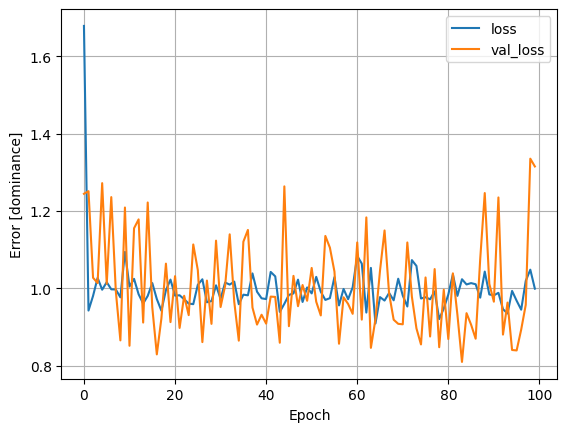

In [15]:
# The training loss (blue) indicates how well the model is fitting the training data, 
# while the validation loss indicates how well the model fits the validation data (20% subsets). 
plot_loss(history)

In [16]:
test_results = {}

test_results['linear_model'] = linear_model.evaluate(
    X_test_feature_selection, y_test, verbose=0)

In [17]:
test_results

{'linear_model': 1.2721644639968872}

In [18]:
# That was a single layer neural network so let's try to do better! Basically one node to learn the entire problem

# here is just a basic mod

standard_dnn_model = keras.Sequential([
      normalizer,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

standard_dnn_model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

standard_dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 64)               129       
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,514
Trainable params: 8,385
Non-trainable params: 129
_________________________________________________________________


In [19]:
history = standard_dnn_model.fit(
    X_train_feature_selection,
    y_train,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

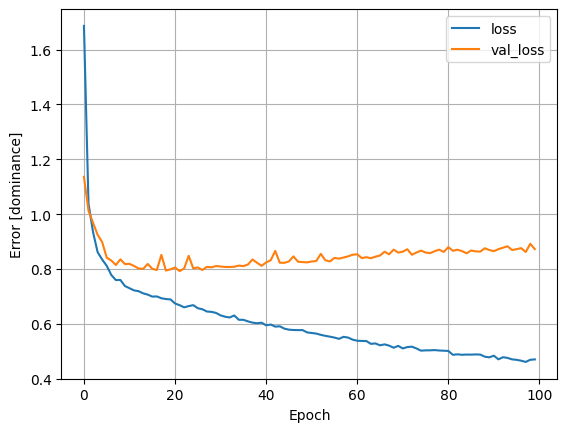

In [20]:
plot_loss(history)

In [21]:
test_results['standard_dnn_model'] = standard_dnn_model.evaluate(
    X_test_feature_selection, y_test, verbose=0)

test_results

{'linear_model': 1.2721644639968872, 'standard_dnn_model': 0.8905330300331116}

# keras_tuner for grid search

In [22]:
# let's use keras_tuner
# https://keras.io/keras_tuner/
# https://keras.io/guides/keras_tuner/getting_started/
import keras_tuner

In [39]:
def build_model(hp):
    model = keras.Sequential()
    #model.add(normalizer)
    model.add(layers.Flatten())
    
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)): # test 1-5 layers of neurons
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32), # how many neurons in our layers? 
                # NOTE that our number of neurons should be 2 to the power of (some number) = [2, 4, 16, 32, 64, ...]
                activation=hp.Choice("activation", ["relu", "tanh"]), # https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6
            )
        )
    '''
    # for single layer you can just add a layer and test different neuron amounts
    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=32, max_value=512, step=32),
            # Tune the activation function to use.
            activation=hp.Choice("activation", ["relu", "tanh"]),
        )
    )
    '''
    # Tune whether to use dropout.
    # https://medium.com/analytics-vidhya/a-simple-introduction-to-dropout-regularization-with-code-5279489dda1e
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
        
    # the output layer - let's just make it a layer with 1 neuron and a RELU activation
    # because we want the numbers to go above 1 and we dont want them negative - it's perfect!
    model.add(layers.Dense(1, activation="relu"))
    
    # Define the optimizer learning rate as a hyperparameter for the Adam optimization
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    
    # Adam tends to be a generally great choice for optimization so we'll stick with that
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mean_absolute_error",
        metrics=["mean_absolute_error"],
    )
    return model

tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10
)

# Start the search and get the best model:
    
tuner.search(X_train_feature_selection, y_train, epochs=100, validation_data=(X_test_feature_selection, y_test))

Trial 10 Complete [00h 00m 23s]
val_loss: 5.438483715057373

Best val_loss So Far: 0.7680091261863708
Total elapsed time: 00h 04m 57s
INFO:tensorflow:Oracle triggered exit


In [61]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)): # test 1-5 layers of neurons
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32), # how many neurons in our layers?
                activation=hp.Choice("activation", ["relu", "tanh"]), # https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6
            )
        )
    '''
    # for single layer you can just add a layer and test different neuron amounts
    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=32, max_value=512, step=32),
            # Tune the activation function to use.
            activation=hp.Choice("activation", ["relu", "tanh"]),
        )
    )
    '''
    # Tune whether to use dropout.
    # https://medium.com/analytics-vidhya/a-simple-introduction-to-dropout-regularization-with-code-5279489dda1e
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
        
    # the output layer - let's just make it a layer with 1 neuron and a RELU activation
    # because we want the numbers to go above 1 and we dont want them negative - it's perfect!
    model.add(layers.Dense(1, activation="relu"))
    
    # Define the optimizer learning rate as a hyperparameter for the Adam optimization
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    
    # Adam tends to be a generally great choice for optimization so we'll stick with that
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mean_absolute_error",
        metrics=["mean_absolute_error"],
    )
    return model

# we'll use a random search but can also do Hyperband or Bayesian Optimization
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10 # can make this larger to get more coverage since it is a RANDOM search
)

# Start the search and get the best model:
    
tuner.search(X_train_feature_selection, y_train, epochs=100, validation_data=(X_test_feature_selection, y_test))


Trial 10 Complete [00h 00m 27s]
val_loss: 0.8245854377746582

Best val_loss So Far: 0.8240228891372681
Total elapsed time: 00h 03m 42s
INFO:tensorflow:Oracle triggered exit


In [40]:
tuner.search_space_summary()

Search space summary
Default search space size: 9
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32

In [41]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 2
units_0: 224
activation: tanh
dropout: True
lr: 0.005461586041849058
units_1: 32
Score: 0.7680091261863708
Trial summary
Hyperparameters:
num_layers: 1
units_0: 256
activation: tanh
dropout: True
lr: 0.0015006869040260927
units_1: 448
units_2: 384
units_3: 416
units_4: 32
Score: 0.7680171132087708
Trial summary
Hyperparameters:
num_layers: 4
units_0: 416
activation: tanh
dropout: True
lr: 0.001236434222402599
units_1: 384
units_2: 64
units_3: 32
units_4: 128
Score: 0.7680281400680542
Trial summary
Hyperparameters:
num_layers: 5
units_0: 64
activation: tanh
dropout: False
lr: 0.0005353006242035114
units_1: 64
units_2: 32
units_3: 32
units_4: 32
Score: 5.438483715057373
Trial summary
Hyperparameters:
num_layers: 4
units_0: 352
activation: tanh
dropout: False
lr: 0.004575754932482191
units_1: 128
units_2: 288
units_3: 416
units_4: 448
Score: 5.438483715057373
Trial summary
Hyp

In [45]:
'''
Trial summary
Hyperparameters:
num_layers: 2
units_0: 224
activation: tanh
dropout: True
lr: 0.005461586041849058
units_1: 32
Score: 0.7680091261863708
'''

tuned_dnn_model = keras.Sequential([
    normalizer,
    layers.Dense(224, activation='tanh'),
    layers.Dropout(0.25),
    layers.Dense(32, activation='tanh'),
    layers.Dropout(0.25),
    layers.Dense(1, activation='relu')
  ])

tuned_dnn_model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.005461586041849058))

tuned_dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 64)               129       
 n)                                                              
                                                                 
 dense_7 (Dense)             (None, 224)               14560     
                                                                 
 dropout_1 (Dropout)         (None, 224)               0         
                                                                 
 dense_8 (Dense)             (None, 32)                7200      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                      

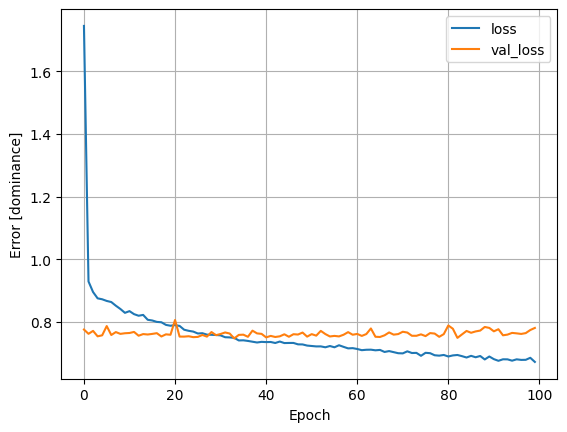

In [46]:
history = tuned_dnn_model.fit(
    X_train_feature_selection,
    y_train,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

plot_loss(history)

In [47]:
test_results['tuned_dnn_model'] = tuned_dnn_model.evaluate(
    X_test_feature_selection, y_test, verbose=0)

test_results

{'linear_model': 1.2721644639968872,
 'standard_dnn_model': 0.8905330300331116,
 'tuned_dnn_model': 0.7526869177818298}

In [54]:
# let's save this best model
save_best_model = tf.keras.callbacks.ModelCheckpoint('keras acoustics tmp/', monitor='val_loss', 
                                  save_best_only=True, save_weights_only=True)

# fit model and save the best (of the 100 epochs) to "keras acoustics tmp" folder
tuned_dnn_model.fit(X_train_feature_selection, y_train, 
              batch_size=64,
              epochs=100,
              validation_data=(X_test_feature_selection, y_test), 
              callbacks=[save_best_model])

Epoch 1/100
113/113 [==============================] - 0s 927us/step - loss: 0.6209 - val_loss: 0.7972
Epoch 2/100
113/113 [==============================] - 0s 595us/step - loss: 0.6208 - val_loss: 0.7977
Epoch 3/100
113/113 [==============================] - 0s 592us/step - loss: 0.6238 - val_loss: 0.8029
Epoch 4/100
113/113 [==============================] - 0s 574us/step - loss: 0.6199 - val_loss: 0.8002
Epoch 5/100
113/113 [==============================] - 0s 690us/step - loss: 0.6196 - val_loss: 0.7955
Epoch 6/100
113/113 [==============================] - 0s 662us/step - loss: 0.6223 - val_loss: 0.7919
Epoch 7/100
113/113 [==============================] - 0s 583us/step - loss: 0.6184 - val_loss: 0.7929
Epoch 8/100
113/113 [==============================] - 0s 588us/step - loss: 0.6216 - val_loss: 0.7944
Epoch 9/100
113/113 [==============================] - 0s 593us/step - loss: 0.6204 - val_loss: 0.7938
Epoch 10/100
113/113 [==============================] - 0s 710us/step - l

Epoch 80/100
113/113 [==============================] - 0s 591us/step - loss: 0.5997 - val_loss: 0.8005
Epoch 81/100
113/113 [==============================] - 0s 579us/step - loss: 0.5956 - val_loss: 0.8069
Epoch 82/100
113/113 [==============================] - 0s 574us/step - loss: 0.5981 - val_loss: 0.8093
Epoch 83/100
113/113 [==============================] - 0s 576us/step - loss: 0.6034 - val_loss: 0.8002
Epoch 84/100
113/113 [==============================] - 0s 576us/step - loss: 0.6018 - val_loss: 0.7987
Epoch 85/100
113/113 [==============================] - 0s 576us/step - loss: 0.5980 - val_loss: 0.8000
Epoch 86/100
113/113 [==============================] - 0s 576us/step - loss: 0.6000 - val_loss: 0.7947
Epoch 87/100
113/113 [==============================] - 0s 576us/step - loss: 0.5973 - val_loss: 0.8087
Epoch 88/100
113/113 [==============================] - 0s 577us/step - loss: 0.5901 - val_loss: 0.8011
Epoch 89/100
113/113 [==============================] - 0s 577us

In [55]:
# reload the best model with:
# tuned_dnn_model.load_weights('keras acoustics tmp/')

# evaluate with
# tuned_dnn_model.evaluate(X_test, y_test, verbose=0)

### now we know which model and hyperparameters maximizes our train and validate data so we can load in our test data and test that best model on it for a final score!

In [ ]:
# MAE FROM RANDOM FOREST

In [48]:
test = pd.read_csv('../Data/Acoustic Data/TEST acoustic data.csv')

In [49]:
X_test = test[all_float_or_int_features].replace((np.inf, -np.inf, np.nan), 0)
X_test_feature_selection = X_test.iloc[:,cols]
y_test = test['dominance_tags']

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

final_model = RandomForestRegressor(min_samples_leaf=10, n_estimators=68) # define the best model with the best parameters here
final_model.fit(X_train_validate_feature_selection, ytrain_validate_dominance)

# evaluate the model
y_pred = final_model.predict(X_test_feature_selection)

# evaluate predictions
mae = mean_absolute_error(y_test, y_pred)

print('mean absolute error on test set (random forest): ', mae)

mean absolute error on test set:  0.7778821301147701


In [56]:
# MAE FROM neural network

In [58]:
# reload the best model with:
tuned_dnn_model.load_weights('keras acoustics tmp/')

# evaluate with:
mae_nn = tuned_dnn_model.evaluate(X_test_feature_selection, y_test, verbose=0)

print('mean absolute error on test set (neural network): ', mae_nn)

mean absolute error on test set (neural network):  0.7860860824584961
